In [8]:
# Essential imports and configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize_scalar
from skimage import io
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration
PIXEL_SIZE_UM = 0.065
FRAME_INTERVAL_MIN = 0.5
BOUNDARY_MARGIN_FRAMES = 3  # Frames to exclude at dataset boundaries
MIN_CYCLE_FRAMES = 4        # Minimum frames for valid cycle
MIN_AREA_DECREASE_THRESHOLD = 0.8  # Reject cycles with >20% area decrease before division

# Data paths - dynamically find project root
PROJECT_ROOT = Path(__file__).parent.parent.parent if '__file__' in globals() else Path.cwd().parent
if not (PROJECT_ROOT / 'data').exists():
    # Fallback: try to find the project root by looking for data directory
    current = Path.cwd()
    while current != current.parent:
        if (current / 'data').exists():
            PROJECT_ROOT = current
            break
        current = current.parent

MEDIUMS = {
    'LB': {
        'tracks': PROJECT_ROOT / 'data/timelapse_data/LB_data/napari/tracks_LB_enhanced.parquet',
        'masks': PROJECT_ROOT / 'data/timelapse_data/LB_data/masks.tif'
    },
    'M9': {
        'tracks': PROJECT_ROOT / 'data/timelapse_data/M9_data/POS1_ROI1/napari/tracks_M9_enhanced.parquet',
        'masks': PROJECT_ROOT / 'data/timelapse_data/M9_data/POS1_ROI1/combined_masks.tif'
    }
}

# Output setup
OUTPUT_DIR = PROJECT_ROOT / 'notebooks/05_tracking_analysis/results/cycle_analysis'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Helper functions
def info(msg): print(f"  {msg}")
def warn(msg): print(f"  {msg}")
def success(msg): print(f" {msg}")
def error(msg): print(f" {msg}")

# Unit conversions
PX2UM2 = PIXEL_SIZE_UM ** 2
frame_to_min = lambda f: f * FRAME_INTERVAL_MIN

print(" Tracking Cycle Analysis - Core Implementation")
print(f" Project root: {PROJECT_ROOT}")
print(f" Output directory: {OUTPUT_DIR}")
print(f" Boundary margin: {BOUNDARY_MARGIN_FRAMES} frames ({BOUNDARY_MARGIN_FRAMES * FRAME_INTERVAL_MIN} min)")
print(f"  Min cycle length: {MIN_CYCLE_FRAMES} frames ({MIN_CYCLE_FRAMES * FRAME_INTERVAL_MIN} min)")

# Validate data paths
print("\n Data file validation:")
for medium, paths in MEDIUMS.items():
    print(f" {medium}:")
    for data_type, path in paths.items():
        exists = path.exists()
        status = "✓" if exists else "❌"
        print(f"   {status} {data_type}: {path.name}")
        if not exists:
            print(f"     Path: {path}")


 Tracking Cycle Analysis - Core Implementation
 Project root: /Users/lucas/Documents/GitHub/ECT
 Output directory: /Users/lucas/Documents/GitHub/ECT/notebooks/05_tracking_analysis/results/cycle_analysis
 Boundary margin: 3 frames (1.5 min)
  Min cycle length: 4 frames (2.0 min)

 Data file validation:
 LB:
   ✓ tracks: tracks_LB_enhanced.parquet
   ✓ masks: masks.tif
 M9:
   ✓ tracks: tracks_M9_enhanced.parquet
   ✓ masks: combined_masks.tif


In [9]:
def load_and_standardize_tracks(file_path, medium_name):
    """Load tracking data with minimal preprocessing."""
    info(f"Loading {medium_name} tracking data")
    
    df = pd.read_parquet(file_path)
    df.columns = df.columns.str.lower()
    
    # Ensure required columns
    required = ['track_id', 't', 'area']
    missing = [col for col in required if col not in df.columns]
    if missing:
        error(f"Missing required columns: {missing}")
        return None
    
    # Add derived columns
    df['medium'] = medium_name
    df['time_min'] = df['t'] * FRAME_INTERVAL_MIN
    df['area_um2'] = df['area'] * PX2UM2
    
    # Handle parent column encoding
    if 'parent' in df.columns:
        # Convert self-parent and invalid parents to NaN
        df.loc[df['parent'] == df['track_id'], 'parent'] = np.nan
        df.loc[df['parent'].isin([-1, 0]), 'parent'] = np.nan
    else:
        df['parent'] = np.nan
        warn(f"No parent column found in {medium_name}")
    
    # Basic filtering
    df = df.dropna(subset=['area_um2'])
    df = df[df['area_um2'] > 0]
    
    info(f"Loaded {len(df)} rows, {df['track_id'].nunique()} tracks")
    return df.sort_values(['track_id', 't']).reset_index(drop=True)

def build_cycle_table(tracks_df, medium_name):
    """
    Build cycle table from tracking data with explicit division detection.
    
    Core logic:
    - Use parent/child relationships to identify divisions
    - Each track represents one cell lifecycle: birth → growth → division/death
    - Division occurs when a track has children that start after it ends
    - Birth is either track start (if has parent) or dataset boundary (if root)
    """
    info(f"Building cycle table for {medium_name}")
    
    # Get dataset boundaries
    t_min, t_max = tracks_df['t'].min(), tracks_df['t'].max()
    
    # Build parent-child mapping
    parent_children = tracks_df.groupby('parent')['track_id'].apply(list).to_dict()
    parent_children = {k: v for k, v in parent_children.items() if pd.notna(k)}
    
    cycles = []
    
    for track_id in tracks_df['track_id'].unique():
        track_data = tracks_df[tracks_df['track_id'] == track_id].sort_values('t')
        
        if len(track_data) < MIN_CYCLE_FRAMES:
            continue
        
        # Extract track timing and areas
        t_start = track_data['t'].iloc[0]
        t_end = track_data['t'].iloc[-1]
        area_start = track_data['area_um2'].iloc[0]
        area_end = track_data['area_um2'].iloc[-1]
        parent = track_data['parent'].iloc[0]
        
        # Check for area decrease (tracking error indicator)
        area_ratio = area_end / area_start if area_start > 0 else 1.0
        if area_ratio < MIN_AREA_DECREASE_THRESHOLD:
            continue  # Skip cycles with significant area decrease
        
        # Determine birth timing
        has_parent = pd.notna(parent)
        is_censored_left = (t_start <= t_min + BOUNDARY_MARGIN_FRAMES) and not has_parent
        
        # Determine division timing
        has_children = track_id in parent_children
        is_censored_right = (t_end >= t_max - BOUNDARY_MARGIN_FRAMES) and not has_children
        
        # Validate division timing if has children
        valid_division = True
        if has_children:
            children = parent_children[track_id]
            child_starts = []
            for child_id in children:
                child_data = tracks_df[tracks_df['track_id'] == child_id]
                if len(child_data) > 0:
                    child_starts.append(child_data['t'].min())
            
            if child_starts:
                # Division should occur at or just before earliest child start
                earliest_child = min(child_starts)
                division_gap = earliest_child - t_end
                if division_gap > 2:  # More than 2 frames gap suggests tracking error
                    valid_division = False
        
        # Create cycle record
        cycle = {
            'cell_id': track_id,
            't_birth': t_start,
            't_div': t_end if has_children else np.nan,
            'birth_time_min': frame_to_min(t_start),
            'div_time_min': frame_to_min(t_end) if has_children else np.nan,
            'area_birth_um2': area_start,
            'area_div_um2': area_end if has_children else np.nan,
            'medium': medium_name,
            'parent_id': parent,
            'has_parent': has_parent,
            'has_children': has_children,
            'is_censored_left': is_censored_left,
            'is_censored_right': is_censored_right,
            'valid_division': valid_division,
            'track_length_frames': len(track_data),
            'area_ratio': area_ratio
        }
        
        # Compute generation time for complete cycles
        if has_children and valid_division:
            cycle['generation_time_min'] = frame_to_min(t_end - t_start)
        else:
            cycle['generation_time_min'] = np.nan
        
        # Mark as valid cycle (complete birth-to-division with no censoring)
        cycle['is_valid_cycle'] = (
            has_parent and has_children and valid_division and 
            not is_censored_left and not is_censored_right and
            cycle['generation_time_min'] >= MIN_CYCLE_FRAMES * FRAME_INTERVAL_MIN
        )
        
        cycles.append(cycle)
    
    cycle_df = pd.DataFrame(cycles)
    
    # Report statistics
    n_total = len(cycle_df)
    n_valid = cycle_df['is_valid_cycle'].sum()
    n_censored_left = cycle_df['is_censored_left'].sum()
    n_censored_right = cycle_df['is_censored_right'].sum()
    n_invalid_division = (~cycle_df['valid_division']).sum()
    
    print(f"\n {medium_name} CYCLE PARSING RESULTS")
    print("-" * 40)
    print(f"Total potential cycles: {n_total}")
    print(f"Valid complete cycles: {n_valid} ({n_valid/n_total*100:.1f}%)")
    print(f"Left censored: {n_censored_left} ({n_censored_left/n_total*100:.1f}%)")
    print(f"Right censored: {n_censored_right} ({n_censored_right/n_total*100:.1f}%)")
    print(f"Invalid divisions: {n_invalid_division} ({n_invalid_division/n_total*100:.1f}%)")
    
    if n_valid > 0:
        gen_times = cycle_df[cycle_df['is_valid_cycle']]['generation_time_min']
        print(f"Generation times: {gen_times.mean():.1f} ± {gen_times.std():.1f} min")
        print(f"                 Range: {gen_times.min():.1f} - {gen_times.max():.1f} min")
    
    return cycle_df

# Load data and build cycle tables
tracks_data = {}
cycle_data = {}

for medium, paths in MEDIUMS.items():
    # Load tracks
    tracks_df = load_and_standardize_tracks(paths['tracks'], medium)
    if tracks_df is not None:
        tracks_data[medium] = tracks_df
        
        # Build cycles
        cycles_df = build_cycle_table(tracks_df, medium)
        cycle_data[medium] = cycles_df
        
        success(f"{medium} cycle parsing completed")
    else:
        error(f"Failed to load {medium} data")

print(f"\n CYCLE PARSING SUMMARY")
print("=" * 30)
for medium, cycles_df in cycle_data.items():
    n_valid = cycles_df['is_valid_cycle'].sum()
    print(f"{medium}: {n_valid} valid cycles")


  Loading LB tracking data
  Loaded 25431 rows, 724 tracks
  Building cycle table for LB

 LB CYCLE PARSING RESULTS
----------------------------------------
Total potential cycles: 640
Valid complete cycles: 299 (46.7%)
Left censored: 2 (0.3%)
Right censored: 315 (49.2%)
Invalid divisions: 0 (0.0%)
Generation times: 23.5 ± 4.5 min
                 Range: 4.5 - 54.0 min
 LB cycle parsing completed
  Loading M9 tracking data
  Loaded 42148 rows, 717 tracks
  Building cycle table for M9

 M9 CYCLE PARSING RESULTS
----------------------------------------
Total potential cycles: 663
Valid complete cycles: 323 (48.7%)
Left censored: 2 (0.3%)
Right censored: 312 (47.1%)
Invalid divisions: 0 (0.0%)
Generation times: 41.8 ± 9.6 min
                 Range: 2.0 - 91.5 min
 M9 cycle parsing completed

 CYCLE PARSING SUMMARY
LB: 299 valid cycles
M9: 323 valid cycles


In [10]:
def load_biomass_data(mask_path, medium_name):
    """Load mask stack and compute population biomass time series."""
    info(f"Loading {medium_name} biomass data")
    
    try:
        masks = io.imread(str(mask_path))
        if masks.ndim == 2:
            masks = masks[np.newaxis, ...]
        elif masks.ndim == 4:
            masks = masks[:, :, :, 0]
        
        biomass_data = []
        for t in range(masks.shape[0]):
            frame_mask = masks[t]
            area_px = np.count_nonzero(frame_mask)
            area_um2 = area_px * PX2UM2
            
            biomass_data.append({
                't': t,
                'time_min': frame_to_min(t),
                'area_um2': area_um2,
                'medium': medium_name
            })
        
        df = pd.DataFrame(biomass_data)
        info(f"Loaded {len(df)} biomass time points")
        return df
        
    except Exception as e:
        error(f"Failed to load {medium_name} biomass: {e}")
        return None

def detect_exponential_window(biomass_df, min_window_doublings=3, r2_threshold=0.99):
    """
    Auto-detect exponential growth window using sliding R² optimization.
    
    Args:
        biomass_df: Population biomass time series
        min_window_doublings: Minimum window length in doublings
        r2_threshold: Minimum R² for exponential fit
    
    Returns:
        dict with window parameters and fit results
    """
    info("Detecting exponential growth window")
    
    time = biomass_df['time_min'].values
    area = biomass_df['area_um2'].values
    log_area = np.log(area + 1e-9)  # Add small epsilon to avoid log(0)
    
    # Estimate minimum window size in frames
    # Rough estimate: if doubling time ~30 min, 3 doublings = 90 min
    rough_doubling_time = 30  # minutes (conservative estimate)
    min_window_min = min_window_doublings * rough_doubling_time
    min_window_frames = int(min_window_min / FRAME_INTERVAL_MIN)
    min_window_frames = max(min_window_frames, 10)  # At least 10 frames
    
    best_r2 = 0
    best_window = None
    window_results = []
    
    # Slide window across time series
    for start_idx in range(len(time) - min_window_frames):
        for end_idx in range(start_idx + min_window_frames, len(time) + 1):
            window_time = time[start_idx:end_idx]
            window_log_area = log_area[start_idx:end_idx]
            
            # Skip if contains invalid values
            if not np.all(np.isfinite(window_log_area)):
                continue
            
            # Linear regression: log(area) = k*t + log(B0)
            slope, intercept, r_value, p_value, std_err = stats.linregress(window_time, window_log_area)
            r2 = r_value ** 2
            
            # Check if slope is reasonable (positive growth)
            if slope <= 0:
                continue
            
            # Check minimum window length in doublings
            window_duration = window_time[-1] - window_time[0]
            doubling_time = np.log(2) / slope
            actual_doublings = window_duration / doubling_time
            
            if actual_doublings < min_window_doublings:
                continue
            
            window_result = {
                'start_idx': start_idx,
                'end_idx': end_idx,
                'start_time': window_time[0],
                'end_time': window_time[-1],
                'duration_min': window_duration,
                'k_min_inv': slope,
                'tau_min': doubling_time,
                'r2': r2,
                'n_doublings': actual_doublings,
                'n_points': len(window_time)
            }
            
            window_results.append(window_result)
            
            # Track best window
            if r2 > best_r2 and r2 >= r2_threshold:
                best_r2 = r2
                best_window = window_result.copy()
    
    if best_window is None:
        warn("No exponential window found meeting criteria")
        # Fall back to longest high-R² window
        if window_results:
            high_r2_windows = [w for w in window_results if w['r2'] >= r2_threshold * 0.95]
            if high_r2_windows:
                best_window = max(high_r2_windows, key=lambda w: w['duration_min'])
                warn(f"Using fallback window with R² = {best_window['r2']:.3f}")
    
    if best_window:
        print(f"\n EXPONENTIAL WINDOW DETECTED")
        print("-" * 35)
        print(f"Time range: {best_window['start_time']:.1f} - {best_window['end_time']:.1f} min")
        print(f"Duration: {best_window['duration_min']:.1f} min ({best_window['n_doublings']:.1f} doublings)")
        print(f"Growth rate k: {best_window['k_min_inv']:.4f} min⁻¹")
        print(f"Doubling time τ: {best_window['tau_min']:.1f} min")
        print(f"R²: {best_window['r2']:.4f}")
        print(f"Data points: {best_window['n_points']}")
    
    return best_window, window_results

def bootstrap_cycle_statistics(cycles_df, n_bootstrap=5000, random_state=42):
    """
    Bootstrap confidence intervals for cycle-based generation time statistics.
    
    Args:
        cycles_df: Cycle table with valid cycles
        n_bootstrap: Number of bootstrap resamples
        random_state: Random seed for reproducibility
    
    Returns:
        Dictionary with point estimates and confidence intervals
    """
    valid_cycles = cycles_df[cycles_df['is_valid_cycle']].copy()
    
    if len(valid_cycles) == 0:
        warn("No valid cycles for bootstrap analysis")
        return None
    
    gen_times = valid_cycles['generation_time_min'].values
    birth_areas = valid_cycles['area_birth_um2'].values
    
    np.random.seed(random_state)
    
    # Bootstrap replicates
    bootstrap_means = []
    bootstrap_weighted_means = []
    
    for _ in range(n_bootstrap):
        # Resample cycles with replacement
        indices = np.random.choice(len(valid_cycles), size=len(valid_cycles), replace=True)
        boot_gen_times = gen_times[indices]
        boot_birth_areas = birth_areas[indices]
        
        # Simple mean
        bootstrap_means.append(np.mean(boot_gen_times))
        
        # Weighted mean (weight by birth area as proxy for lineage contribution)
        if np.all(boot_birth_areas > 0):
            weights = boot_birth_areas / np.sum(boot_birth_areas)
            weighted_mean = np.sum(weights * boot_gen_times)
            bootstrap_weighted_means.append(weighted_mean)
        else:
            bootstrap_weighted_means.append(np.mean(boot_gen_times))
    
    # Compute confidence intervals
    def get_ci(values, alpha=0.05):
        return np.percentile(values, [100*alpha/2, 100*(1-alpha/2)])
    
    results = {
        'n_cycles': len(valid_cycles),
        'mean_gen_time': np.mean(gen_times),
        'mean_gen_time_ci': get_ci(bootstrap_means),
        'weighted_mean_gen_time': np.mean(bootstrap_weighted_means),
        'weighted_mean_ci': get_ci(bootstrap_weighted_means),
        'bootstrap_means': np.array(bootstrap_means),
        'bootstrap_weighted_means': np.array(bootstrap_weighted_means)
    }
    
    return results

# Load biomass data and detect exponential windows
biomass_data = {}
exponential_windows = {}

for medium, paths in MEDIUMS.items():
    # Load biomass
    biomass_df = load_biomass_data(paths['masks'], medium)
    if biomass_df is not None:
        biomass_data[medium] = biomass_df
        
        # Detect exponential window
        best_window, all_windows = detect_exponential_window(biomass_df)
        exponential_windows[medium] = {
            'best': best_window,
            'all': all_windows
        }
        
        if best_window:
            success(f"{medium} exponential window detected: {best_window['start_time']:.1f}-{best_window['end_time']:.1f} min")
        else:
            warn(f"No suitable exponential window found for {medium}")

# Bootstrap cycle statistics
cycle_stats = {}
for medium, cycles_df in cycle_data.items():
    stats_result = bootstrap_cycle_statistics(cycles_df)
    if stats_result:
        cycle_stats[medium] = stats_result
        
        print(f"\n {medium} CYCLE STATISTICS")
        print("-" * 30)
        print(f"Valid cycles: {stats_result['n_cycles']}")
        print(f"Mean generation time: {stats_result['mean_gen_time']:.1f} min")
        print(f"95% CI: {stats_result['mean_gen_time_ci'][0]:.1f} - {stats_result['mean_gen_time_ci'][1]:.1f} min")
        print(f"Weighted mean: {stats_result['weighted_mean_gen_time']:.1f} min")
        print(f"95% CI: {stats_result['weighted_mean_ci'][0]:.1f} - {stats_result['weighted_mean_ci'][1]:.1f} min")

success("Core cycle analysis and exponential window detection completed")


  Loading LB biomass data
  Loaded 361 biomass time points
  Detecting exponential growth window

 EXPONENTIAL WINDOW DETECTED
-----------------------------------
Time range: 29.0 - 118.5 min
Duration: 89.5 min (3.7 doublings)
Growth rate k: 0.0287 min⁻¹
Doubling time τ: 24.1 min
R²: 0.9999
Data points: 180
 LB exponential window detected: 29.0-118.5 min
  Loading M9 biomass data
  Loaded 601 biomass time points
  Detecting exponential growth window

 EXPONENTIAL WINDOW DETECTED
-----------------------------------
Time range: 83.5 - 243.0 min
Duration: 159.5 min (3.5 doublings)
Growth rate k: 0.0154 min⁻¹
Doubling time τ: 44.9 min
R²: 0.9999
Data points: 320
 M9 exponential window detected: 83.5-243.0 min

 LB CYCLE STATISTICS
------------------------------
Valid cycles: 299
Mean generation time: 23.5 min
95% CI: 23.0 - 24.0 min
Weighted mean: 23.2 min
95% CI: 22.7 - 23.7 min

 M9 CYCLE STATISTICS
------------------------------
Valid cycles: 323
Mean generation time: 41.8 min
95% CI: 4

In [11]:
def bootstrap_painter_marr_ratio(cycles_df, biomass_df, exp_window, n_bootstrap=2000, random_state=42):
    """
    Paired bootstrap for Painter-Marr ratio with proper uncertainty propagation.
    
    R_PM = τ_pop / ⟨T⟩_weighted
    
    Args:
        cycles_df: Cycle table
        biomass_df: Population biomass data
        exp_window: Exponential window parameters
        n_bootstrap: Number of bootstrap resamples
        random_state: Random seed
        
    Returns:
        Dict with R_PM estimate and confidence intervals
    """
    if exp_window is None:
        warn("No exponential window - cannot compute Painter-Marr ratio")
        return None
    
    valid_cycles = cycles_df[cycles_df['is_valid_cycle']].copy()
    if len(valid_cycles) == 0:
        warn("No valid cycles for Painter-Marr analysis")
        return None
    
    # Extract exponential window biomass data
    biomass_window = biomass_df[
        (biomass_df['time_min'] >= exp_window['start_time']) & 
        (biomass_df['time_min'] <= exp_window['end_time'])
    ].copy()
    
    if len(biomass_window) < 5:
        warn("Insufficient biomass data in exponential window")
        return None
    
    info("Computing Painter-Marr ratio with paired bootstrap")
    
    # Original estimates
    gen_times = valid_cycles['generation_time_min'].values
    birth_areas = valid_cycles['area_birth_um2'].values
    
    # Weighted mean generation time (original)
    weights = birth_areas / np.sum(birth_areas)
    tau_T_orig = np.sum(weights * gen_times)
    
    # Population doubling time (original) 
    tau_pop_orig = exp_window['tau_min']
    r_pm_orig = tau_pop_orig / tau_T_orig
    
    # Bootstrap replicates
    np.random.seed(random_state)
    
    tau_T_boot = []
    tau_pop_boot = []
    r_pm_boot = []
    
    for i in range(n_bootstrap):
        # 1. Resample cycles (for τ_T)
        cycle_indices = np.random.choice(len(valid_cycles), size=len(valid_cycles), replace=True)
        boot_gen_times = gen_times[cycle_indices]
        boot_birth_areas = birth_areas[cycle_indices]
        
        boot_weights = boot_birth_areas / np.sum(boot_birth_areas)
        tau_T_i = np.sum(boot_weights * boot_gen_times)
        
        # 2. Block bootstrap biomass data (for τ_pop)
        block_size = 5  # 5-frame blocks to preserve temporal correlation
        n_blocks = len(biomass_window) // block_size
        
        if n_blocks > 1:
            block_indices = np.random.choice(n_blocks, size=n_blocks, replace=True)
            boot_biomass_data = []
            
            for block_idx in block_indices:
                start_idx = block_idx * block_size
                end_idx = min(start_idx + block_size, len(biomass_window))
                boot_biomass_data.extend(biomass_window.iloc[start_idx:end_idx].to_dict('records'))
            
            boot_biomass_df = pd.DataFrame(boot_biomass_data)
            
            # Refit exponential model
            if len(boot_biomass_df) >= 5:
                time_boot = boot_biomass_df['time_min'].values
                area_boot = boot_biomass_df['area_um2'].values
                log_area_boot = np.log(area_boot + 1e-9)
                
                if np.all(np.isfinite(log_area_boot)):
                    slope, _, _, _, _ = stats.linregress(time_boot, log_area_boot)
                    if slope > 0:
                        tau_pop_i = np.log(2) / slope
                    else:
                        tau_pop_i = tau_pop_orig  # Fall back to original
                else:
                    tau_pop_i = tau_pop_orig
            else:
                tau_pop_i = tau_pop_orig
        else:
            tau_pop_i = tau_pop_orig  # Fall back if insufficient blocks
        
        # 3. Compute ratio
        if tau_T_i > 0:
            r_pm_i = tau_pop_i / tau_T_i
        else:
            r_pm_i = np.nan
        
        tau_T_boot.append(tau_T_i)
        tau_pop_boot.append(tau_pop_i)
        r_pm_boot.append(r_pm_i)
    
    # Remove any NaN values
    r_pm_boot = np.array(r_pm_boot)
    valid_mask = np.isfinite(r_pm_boot)
    r_pm_boot = r_pm_boot[valid_mask]
    tau_T_boot = np.array(tau_T_boot)[valid_mask]
    tau_pop_boot = np.array(tau_pop_boot)[valid_mask]
    
    if len(r_pm_boot) < n_bootstrap * 0.8:
        warn(f"Many bootstrap failures: {len(r_pm_boot)}/{n_bootstrap} valid")
    
    # Confidence intervals
    def get_ci(values, alpha=0.05):
        if len(values) > 0:
            return np.percentile(values, [100*alpha/2, 100*(1-alpha/2)])
        else:
            return [np.nan, np.nan]
    
    results = {
        'tau_T': tau_T_orig,
        'tau_T_ci': get_ci(tau_T_boot),
        'tau_pop': tau_pop_orig,
        'tau_pop_ci': get_ci(tau_pop_boot),
        'r_pm': r_pm_orig,
        'r_pm_ci': get_ci(r_pm_boot),
        'n_cycles': len(valid_cycles),
        'n_bootstrap_valid': len(r_pm_boot),
        'balanced_growth_test': np.abs(r_pm_orig - 1.0) < 0.2,  # ±20% tolerance
        'bootstrap_arrays': {
            'tau_T': tau_T_boot,
            'tau_pop': tau_pop_boot,
            'r_pm': r_pm_boot
        }
    }
    
    return results

def compare_track_vs_cycle_bias(tracks_df, cycles_df, medium_name):
    """
    Compare naive track duration vs proper cycle generation times to quantify bias.
    """
    info(f"Analyzing track vs cycle bias for {medium_name}")
    
    # Track-based generation times (naive approach)
    track_durations = []
    for track_id in tracks_df['track_id'].unique():
        track_data = tracks_df[tracks_df['track_id'] == track_id]
        if len(track_data) >= MIN_CYCLE_FRAMES:
            duration = (track_data['t'].max() - track_data['t'].min()) * FRAME_INTERVAL_MIN
            if 5 <= duration <= 200:  # Reasonable bounds
                track_durations.append(duration)
    
    # Cycle-based generation times (proper approach)
    valid_cycles = cycles_df[cycles_df['is_valid_cycle']]
    cycle_gen_times = valid_cycles['generation_time_min'].values
    
    if len(track_durations) == 0 or len(cycle_gen_times) == 0:
        warn(f"Insufficient data for bias analysis in {medium_name}")
        return None
    
    track_mean = np.mean(track_durations)
    cycle_mean = np.mean(cycle_gen_times)
    bias = cycle_mean - track_mean
    relative_bias = bias / track_mean * 100
    
    results = {
        'n_tracks': len(track_durations),
        'n_cycles': len(cycle_gen_times),
        'track_mean': track_mean,
        'cycle_mean': cycle_mean,
        'bias_correction': bias,
        'relative_bias_percent': relative_bias
    }
    
    print(f"\n {medium_name} BIAS ANALYSIS")
    print("-" * 30)
    print(f"Track durations (naive): {track_mean:.1f} min (n={len(track_durations)})")
    print(f"Cycle times (proper): {cycle_mean:.1f} min (n={len(cycle_gen_times)})")
    print(f"Bias correction: +{bias:.1f} min (+{relative_bias:.1f}%)")
    
    return results

# Compute Painter-Marr ratios and bias analysis
painter_marr_results = {}
bias_analyses = {}

for medium in cycle_data.keys():
    if medium in biomass_data and medium in exponential_windows:
        cycles_df = cycle_data[medium]
        biomass_df = biomass_data[medium]
        exp_window = exponential_windows[medium]['best']
        
        # Painter-Marr analysis
        pm_result = bootstrap_painter_marr_ratio(cycles_df, biomass_df, exp_window)
        if pm_result:
            painter_marr_results[medium] = pm_result
            
            print(f"\n {medium} PAINTER-MARR ANALYSIS")
            print("-" * 35)
            print(f"Weighted ⟨T⟩: {pm_result['tau_T']:.1f} min (95% CI: {pm_result['tau_T_ci'][0]:.1f}-{pm_result['tau_T_ci'][1]:.1f})")
            print(f"Population τ_pop: {pm_result['tau_pop']:.1f} min (95% CI: {pm_result['tau_pop_ci'][0]:.1f}-{pm_result['tau_pop_ci'][1]:.1f})")
            print(f"R_PM ratio: {pm_result['r_pm']:.2f} (95% CI: {pm_result['r_pm_ci'][0]:.2f}-{pm_result['r_pm_ci'][1]:.2f})")
            print(f"Balanced growth: {' PASS' if pm_result['balanced_growth_test'] else '  DEVIATION'}")
            print(f"Bootstrap success: {pm_result['n_bootstrap_valid']}/2000")
        
        # Bias analysis
        if medium in tracks_data:
            bias_result = compare_track_vs_cycle_bias(tracks_data[medium], cycles_df, medium)
            if bias_result:
                bias_analyses[medium] = bias_result

# Summary comparison
print(f"\n CROSS-SCALE VALIDATION SUMMARY")
print("=" * 50)
print(f"{'Medium':<8} {'⟨T⟩ (min)':<12} {'τ_pop (min)':<12} {'R_PM':<8} {'Balanced?':<10}")
print("-" * 50)

for medium, pm_result in painter_marr_results.items():
    balanced_status = " YES" if pm_result['balanced_growth_test'] else "  NO"
    print(f"{medium:<8} {pm_result['tau_T']:<12.1f} {pm_result['tau_pop']:<12.1f} {pm_result['r_pm']:<8.2f} {balanced_status:<10}")

success("Painter-Marr analysis completed")


  Computing Painter-Marr ratio with paired bootstrap

 LB PAINTER-MARR ANALYSIS
-----------------------------------
Weighted ⟨T⟩: 23.2 min (95% CI: 22.7-23.7)
Population τ_pop: 24.1 min (95% CI: 24.0-24.2)
R_PM ratio: 1.04 (95% CI: 1.02-1.06)
Balanced growth:  PASS
Bootstrap success: 2000/2000
  Analyzing track vs cycle bias for LB

 LB BIAS ANALYSIS
------------------------------
Track durations (naive): 20.4 min (n=601)
Cycle times (proper): 23.5 min (n=299)
Bias correction: +3.1 min (+15.2%)
  Computing Painter-Marr ratio with paired bootstrap

 M9 PAINTER-MARR ANALYSIS
-----------------------------------
Weighted ⟨T⟩: 41.2 min (95% CI: 40.1-42.3)
Population τ_pop: 44.9 min (95% CI: 44.9-45.0)
R_PM ratio: 1.09 (95% CI: 1.06-1.12)
Balanced growth:  PASS
Bootstrap success: 2000/2000
  Analyzing track vs cycle bias for M9

 M9 BIAS ANALYSIS
------------------------------
Track durations (naive): 33.9 min (n=598)
Cycle times (proper): 41.8 min (n=323)
Bias correction: +7.9 min (+23.2%)


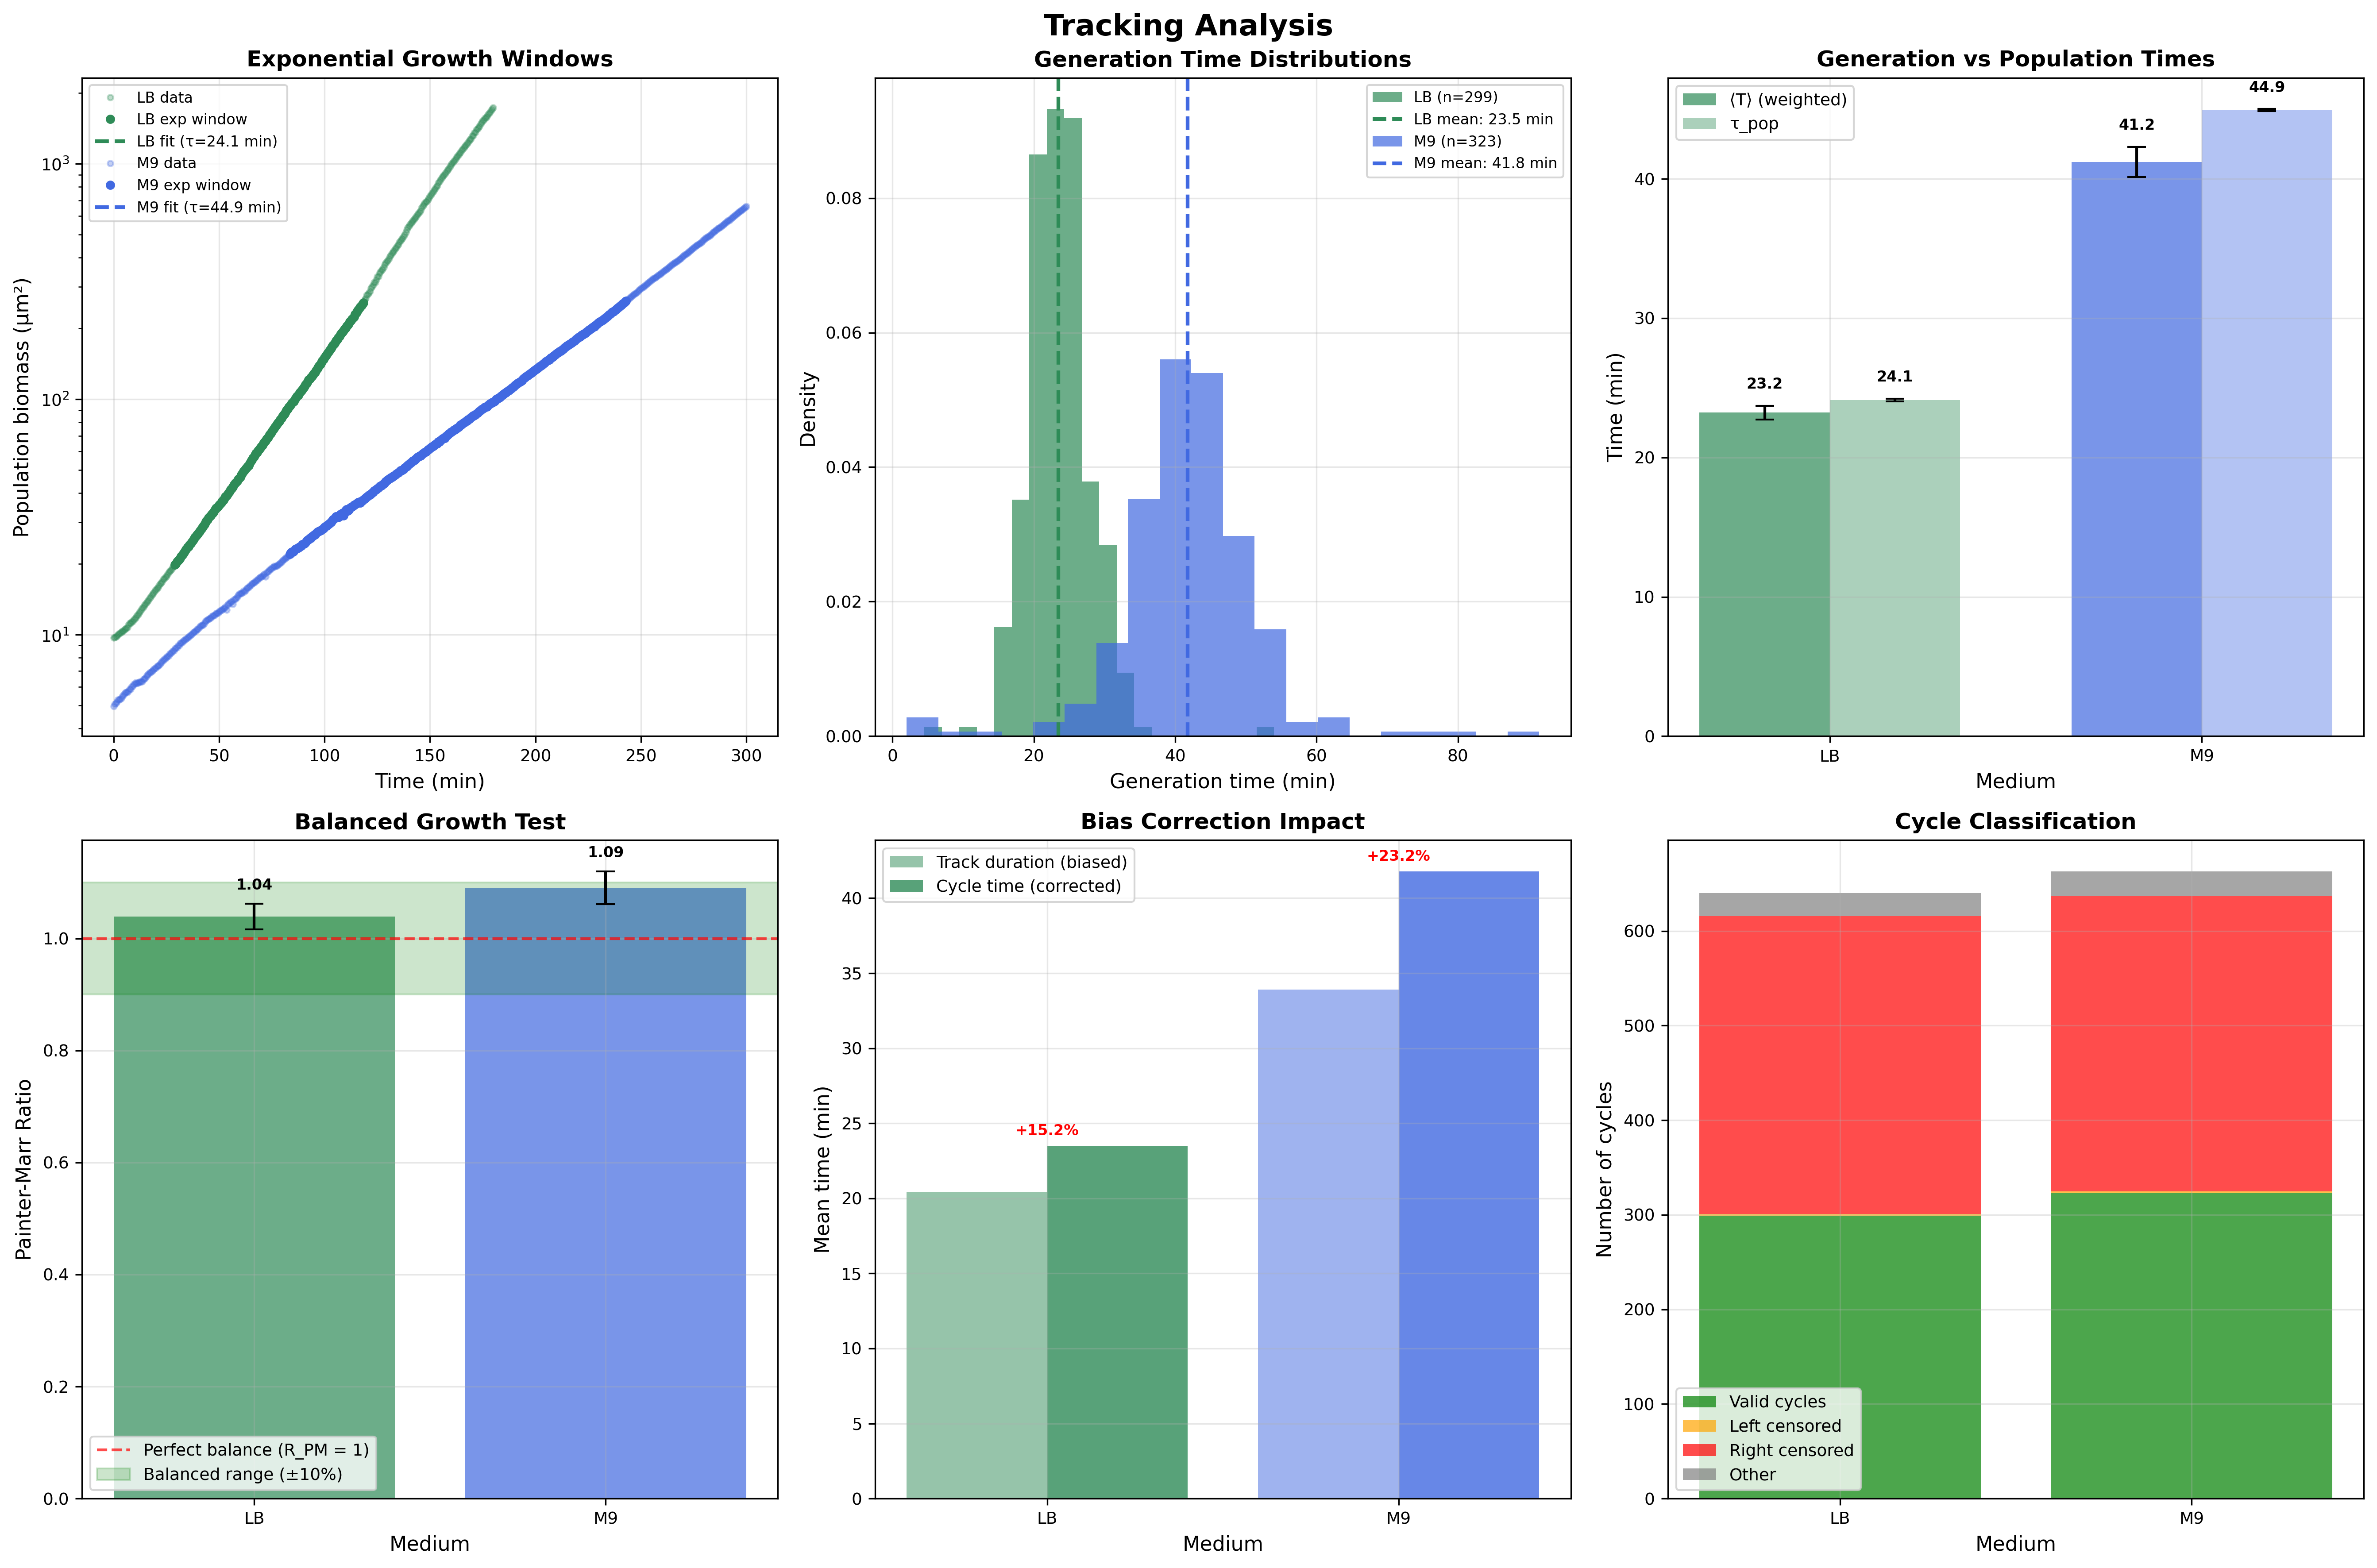

 Summary visualizations created
  Results exported to /Users/lucas/Documents/GitHub/ECT/notebooks/05_tracking_analysis/results/cycle_analysis
 CSV files: cycle tables and summary statistics
 LaTeX files: table and macros for thesis integration
 Figure: cycle_analysis_summary.pdf

 CYCLE ANALYSIS COMPLETE
📂 All outputs saved to: /Users/lucas/Documents/GitHub/ECT/notebooks/05_tracking_analysis/results/cycle_analysis
 Key findings:
   LB: R_PM = 1.04 → BALANCED
   M9: R_PM = 1.09 → BALANCED
 Bias corrections applied:
   LB: +15.2% generation time correction
   M9: +23.2% generation time correction


In [15]:
def create_summary_visualizations():
    """Create comprehensive visualization of cycle analysis results."""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Tracking Analysis', fontsize=16, fontweight='bold')
    
    colors = {'LB': '#2E8B57', 'M9': '#4169E1'}
    
    # Panel 1: Exponential windows
    ax = axes[0, 0]
    for medium, biomass_df in biomass_data.items():
        exp_window = exponential_windows[medium]['best']
        color = colors[medium]
        
        time = biomass_df['time_min'].values
        area = biomass_df['area_um2'].values
        
        # Plot full data
        ax.semilogy(time, area, 'o', color=color, alpha=0.3, markersize=3, label=f'{medium} data')
        
        # Highlight exponential window
        if exp_window:
            window_mask = (time >= exp_window['start_time']) & (time <= exp_window['end_time'])
            ax.semilogy(time[window_mask], area[window_mask], 'o', color=color, markersize=4, 
                       label=f'{medium} exp window')
            
            # Plot fit line
            t_fit = np.linspace(exp_window['start_time'], exp_window['end_time'], 100)
            B0_est = np.exp(np.log(area[window_mask][0]) - exp_window['k_min_inv'] * time[window_mask][0])
            area_fit = B0_est * np.exp(exp_window['k_min_inv'] * t_fit)
            ax.plot(t_fit, area_fit, '--', color=color, linewidth=2, 
                   label=f'{medium} fit (τ={exp_window["tau_min"]:.1f} min)')
    
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Population biomass (µm²)')
    ax.set_title('Exponential Growth Windows', fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Panel 2: Generation time distributions
    ax = axes[0, 1]
    for medium, cycles_df in cycle_data.items():
        valid_cycles = cycles_df[cycles_df['is_valid_cycle']]
        if len(valid_cycles) > 0:
            gen_times = valid_cycles['generation_time_min']
            color = colors[medium]
            
            ax.hist(gen_times, bins=20, alpha=0.7, color=color, density=True,
                   label=f'{medium} (n={len(gen_times)})')
            
            # Add mean line
            mean_gen = gen_times.mean()
            ax.axvline(mean_gen, color=color, linestyle='--', linewidth=2,
                      label=f'{medium} mean: {mean_gen:.1f} min')
    
    ax.set_xlabel('Generation time (min)')
    ax.set_ylabel('Density')
    ax.set_title('Generation Time Distributions', fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Panel 3: Painter-Marr comparison
    ax = axes[0, 2]
    media_names = []
    tau_T_values = []
    tau_pop_values = []
    r_pm_values = []
    tau_T_errors = []
    tau_pop_errors = []
    r_pm_errors = []
    
    for medium, pm_result in painter_marr_results.items():
        media_names.append(medium)
        tau_T_values.append(pm_result['tau_T'])
        tau_pop_values.append(pm_result['tau_pop'])
        r_pm_values.append(pm_result['r_pm'])
        
        # Error bars (asymmetric)
        tau_T_ci = pm_result['tau_T_ci']
        tau_pop_ci = pm_result['tau_pop_ci']
        r_pm_ci = pm_result['r_pm_ci']
        
        tau_T_errors.append([[pm_result['tau_T'] - tau_T_ci[0]], [tau_T_ci[1] - pm_result['tau_T']]])
        tau_pop_errors.append([[pm_result['tau_pop'] - tau_pop_ci[0]], [tau_pop_ci[1] - pm_result['tau_pop']]])
    
    x = np.arange(len(media_names))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, tau_T_values, width, 
                   yerr=np.array(tau_T_errors).squeeze().T,
                   color=[colors[m] for m in media_names], alpha=0.7, 
                   label='⟨T⟩ (weighted)', capsize=5)
    bars2 = ax.bar(x + width/2, tau_pop_values, width, 
                   yerr=np.array(tau_pop_errors).squeeze().T,
                   color=[colors[m] for m in media_names], alpha=0.4, 
                   label='τ_pop', capsize=5)
    
    ax.set_xlabel('Medium')
    ax.set_ylabel('Time (min)')
    ax.set_title('Generation vs Population Times', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(media_names)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add value annotations
    for i, (medium, bars) in enumerate(zip(media_names, [bars1, bars2])):
        pm_result = painter_marr_results[medium]
        ax.text(i - width/2, tau_T_values[i] + tau_T_errors[i][1][0] + 1,
               f'{tau_T_values[i]:.1f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
        ax.text(i + width/2, tau_pop_values[i] + tau_pop_errors[i][1][0] + 1,
               f'{tau_pop_values[i]:.1f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # Panel 4: R_PM ratios
    ax = axes[1, 0]
    r_pm_errors_plot = []
    for medium in media_names:
        pm_result = painter_marr_results[medium]
        r_pm_ci = pm_result['r_pm_ci']
        r_pm_errors_plot.append([[pm_result['r_pm'] - r_pm_ci[0]], [r_pm_ci[1] - pm_result['r_pm']]])
    
    bars = ax.bar(x, r_pm_values, color=[colors[m] for m in media_names], alpha=0.7,
                 yerr=np.array(r_pm_errors_plot).squeeze().T, capsize=5)
    
    # Unity line
    ax.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Perfect balance (R_PM = 1)')
    ax.axhspan(0.9, 1.1, alpha=0.2, color='green', label='Balanced range (±10%)')
    
    ax.set_xlabel('Medium')
    ax.set_ylabel('Painter-Marr Ratio')
    ax.set_title('Balanced Growth Test', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(media_names)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add value annotations
    for i, (medium, val) in enumerate(zip(media_names, r_pm_values)):
        pm_result = painter_marr_results[medium]
        error_top = r_pm_errors_plot[i][1][0]
        ax.text(i, val + error_top + 0.02, f'{val:.2f}', ha='center', va='bottom', 
               fontsize=8, fontweight='bold')
    
    # Panel 5: Bias correction comparison
    ax = axes[1, 1]
    if bias_analyses:
        bias_media = list(bias_analyses.keys())
        track_means = [bias_analyses[m]['track_mean'] for m in bias_media]
        cycle_means = [bias_analyses[m]['cycle_mean'] for m in bias_media]
        
        x_bias = np.arange(len(bias_media))
        ax.bar(x_bias - 0.2, track_means, 0.4, color=[colors[m] for m in bias_media], 
               alpha=0.5, label='Track duration (biased)')
        ax.bar(x_bias + 0.2, cycle_means, 0.4, color=[colors[m] for m in bias_media], 
               alpha=0.8, label='Cycle time (corrected)')
        
        ax.set_xlabel('Medium')
        ax.set_ylabel('Mean time (min)')
        ax.set_title('Bias Correction Impact', fontweight='bold')
        ax.set_xticks(x_bias)
        ax.set_xticklabels(bias_media)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add bias magnitude annotations
        for i, medium in enumerate(bias_media):
            bias_val = bias_analyses[medium]['relative_bias_percent']
            ax.text(i, max(track_means[i], cycle_means[i]) + 0.5, f'+{bias_val:.1f}%', 
                   ha='center', va='bottom', fontsize=8, fontweight='bold', color='red')
    
    # Panel 6: Cycle counts summary
    ax = axes[1, 2]
    cycle_summary_data = []
    for medium, cycles_df in cycle_data.items():
        n_total = len(cycles_df)
        n_valid = cycles_df['is_valid_cycle'].sum()
        n_censored_left = cycles_df['is_censored_left'].sum()
        n_censored_right = cycles_df['is_censored_right'].sum()
        
        cycle_summary_data.append({
            'medium': medium,
            'valid': n_valid,
            'censored_left': n_censored_left,
            'censored_right': n_censored_right,
            'other': n_total - n_valid - n_censored_left - n_censored_right
        })
    
    if cycle_summary_data:
        df_summary = pd.DataFrame(cycle_summary_data)
        
        bottoms = np.zeros(len(df_summary))
        categories = ['valid', 'censored_left', 'censored_right', 'other']
        category_colors = ['green', 'orange', 'red', 'gray']
        category_labels = ['Valid cycles', 'Left censored', 'Right censored', 'Other']
        
        for i, (cat, color, label) in enumerate(zip(categories, category_colors, category_labels)):
            values = df_summary[cat].values
            ax.bar(df_summary['medium'], values, bottom=bottoms, 
                   color=color, alpha=0.7, label=label)
            bottoms += values
        
        ax.set_xlabel('Medium')
        ax.set_ylabel('Number of cycles')
        ax.set_title('Cycle Classification', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'cycle_analysis_summary.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    success("Summary visualizations created")

def export_results():
    """Export results in multiple formats for thesis integration."""
    
    # 1. Cycle tables
    for medium, cycles_df in cycle_data.items():
        cycles_df.to_csv(OUTPUT_DIR / f'cycles_{medium}_complete.csv', index=False)
        
        # Valid cycles only
        valid_cycles = cycles_df[cycles_df['is_valid_cycle']]
        valid_cycles.to_csv(OUTPUT_DIR / f'cycles_{medium}_valid.csv', index=False)
    
    # 2. Summary statistics table
    summary_rows = []
    for medium in painter_marr_results.keys():
        pm_result = painter_marr_results[medium]
        bias_result = bias_analyses.get(medium, {})
        exp_window = exponential_windows[medium]['best']
        
        summary_rows.append({
            'medium': medium,
            'n_valid_cycles': pm_result['n_cycles'],
            'mean_gen_time_min': pm_result['tau_T'],
            'gen_time_ci_low': pm_result['tau_T_ci'][0],
            'gen_time_ci_high': pm_result['tau_T_ci'][1],
            'pop_doubling_time_min': pm_result['tau_pop'],
            'pop_tau_ci_low': pm_result['tau_pop_ci'][0],
            'pop_tau_ci_high': pm_result['tau_pop_ci'][1],
            'painter_marr_ratio': pm_result['r_pm'],
            'r_pm_ci_low': pm_result['r_pm_ci'][0],
            'r_pm_ci_high': pm_result['r_pm_ci'][1],
            'balanced_growth': pm_result['balanced_growth_test'],
            'exp_window_start_min': exp_window['start_time'] if exp_window else np.nan,
            'exp_window_end_min': exp_window['end_time'] if exp_window else np.nan,
            'exp_window_r2': exp_window['r2'] if exp_window else np.nan,
            'bias_correction_min': bias_result.get('bias_correction', np.nan),
            'relative_bias_percent': bias_result.get('relative_bias_percent', np.nan)
        })
    
    summary_df = pd.DataFrame(summary_rows)
    summary_df.to_csv(OUTPUT_DIR / 'tracking_cycle_summary.csv', index=False)
    
    # 3. LaTeX table
    latex_table = "\\begin{table}[ht]\n\\centering\n\\caption{Tracking cycle analysis summary}\n"
    latex_table += "\\begin{tabular}{lcccccc}\n\\toprule\n"
    latex_table += "Medium & $N_{cycles}$ & $\\langle T \\rangle$ (min) & $\\tau_{pop}$ (min) & $R_{PM}$ & Balanced & Bias (\\%) \\\\\n"
    latex_table += "\\midrule\n"
    
    for _, row in summary_df.iterrows():
        balanced_symbol = "✓" if row['balanced_growth'] else "✗"
        latex_table += f"{row['medium']} & {row['n_valid_cycles']} & "
        latex_table += f"{row['mean_gen_time_min']:.1f} & {row['pop_doubling_time_min']:.1f} & "
        latex_table += f"{row['painter_marr_ratio']:.2f} & {balanced_symbol} & "
        latex_table += f"{row['relative_bias_percent']:.1f} \\\\\n"
    
    latex_table += "\\bottomrule\n\\end{tabular}\n\\end{table}\n"
    
    with open(OUTPUT_DIR / 'cycle_summary_table.tex', 'w') as f:
        f.write(latex_table)
    
    # 4. LaTeX macros
    latex_macros = "% Auto-generated LaTeX macros for cycle analysis\n"
    for medium, pm_result in painter_marr_results.items():
        prefix = medium.upper()
        latex_macros += f"\\newcommand{{\\{prefix}GenTime}}{{{pm_result['tau_T']:.1f}}}\n"
        latex_macros += f"\\newcommand{{\\{prefix}PopTime}}{{{pm_result['tau_pop']:.1f}}}\n"
        latex_macros += f"\\newcommand{{\\{prefix}PainterMarr}}{{{pm_result['r_pm']:.2f}}}\n"
        latex_macros += f"\\newcommand{{\\{prefix}ValidCycles}}{{{pm_result['n_cycles']}}}\n"
        
        if medium in bias_analyses:
            bias_pct = bias_analyses[medium]['relative_bias_percent']
            latex_macros += f"\\newcommand{{\\{prefix}BiasCorrection}}{{{bias_pct:.1f}}}\n"
    
    with open(OUTPUT_DIR / 'cycle_analysis_macros.tex', 'w') as f:
        f.write(latex_macros)
    
    info(f"Results exported to {OUTPUT_DIR}")
    print(f" CSV files: cycle tables and summary statistics")
    print(f" LaTeX files: table and macros for thesis integration")
    print(f" Figure: cycle_analysis_summary.pdf")

# Create visualizations and export results
if painter_marr_results:
    create_summary_visualizations()
    export_results()
    
    print(f"\n CYCLE ANALYSIS COMPLETE")
    print("=" * 40)
    print(f"📂 All outputs saved to: {OUTPUT_DIR}")
    print(" Key findings:")
    for medium, pm_result in painter_marr_results.items():
        status = "BALANCED" if pm_result['balanced_growth_test'] else "IMBALANCED"
        print(f"   {medium}: R_PM = {pm_result['r_pm']:.2f} → {status}")
    
    if bias_analyses:
        print(" Bias corrections applied:")
        for medium, bias_result in bias_analyses.items():
            print(f"   {medium}: +{bias_result['relative_bias_percent']:.1f}% generation time correction")
else:
    warn("No Painter-Marr results available for export")


In [ ]:
# # Optional: Size control analysis (P3 priority)
# def analyze_size_control(cycles_df, medium_name, min_cycles=50):
#     """
#     Analyze size control mechanisms: adder vs sizer vs timer.
    
#     Args:
#         cycles_df: Cycle table with birth and division areas
#         medium_name: Name of medium
#         min_cycles: Minimum cycles required for analysis
        
#     Returns:
#         Dictionary with size control analysis results
#     """
#     valid_cycles = cycles_df[cycles_df['is_valid_cycle']].copy()
    
#     if len(valid_cycles) < min_cycles:
#         warn(f"Insufficient cycles for size control analysis in {medium_name}: {len(valid_cycles)} < {min_cycles}")
#         return None
    
#     # Extract size metrics
#     birth_areas = valid_cycles['area_birth_um2'].values
#     div_areas = valid_cycles['area_div_um2'].values
#     added_areas = div_areas - birth_areas
#     gen_times = valid_cycles['generation_time_min'].values
    
#     # Remove outliers (>3 sigma)
#     def remove_outliers(data):
#         mean, std = np.mean(data), np.std(data)
#         mask = np.abs(data - mean) < 3 * std
#         return mask
    
#     outlier_mask = (remove_outliers(birth_areas) & 
#                    remove_outliers(div_areas) & 
#                    remove_outliers(added_areas) &
#                    remove_outliers(gen_times))
    
#     if outlier_mask.sum() < min_cycles * 0.8:
#         warn(f"Too many outliers removed for {medium_name}")
#         return None
    
#     # Apply outlier filter
#     birth_areas = birth_areas[outlier_mask]
#     div_areas = div_areas[outlier_mask]
#     added_areas = added_areas[outlier_mask]
#     gen_times = gen_times[outlier_mask]
    
#     # Size control tests
#     results = {}
    
#     # 1. Adder test: ΔA independent of A_birth (slope ≈ 0)
#     slope_adder, intercept_adder, r_adder, p_adder, se_adder = stats.linregress(birth_areas, added_areas)
#     results['adder_slope'] = slope_adder
#     results['adder_r2'] = r_adder ** 2
#     results['adder_p_value'] = p_adder
#     results['adder_test'] = abs(slope_adder) < 0.1  # Slope near zero
    
#     # 2. Sizer test: A_div independent of A_birth (slope ≈ 0)
#     slope_sizer, intercept_sizer, r_sizer, p_sizer, se_sizer = stats.linregress(birth_areas, div_areas)
#     results['sizer_slope'] = slope_sizer
#     results['sizer_r2'] = r_sizer ** 2
#     results['sizer_p_value'] = p_sizer
#     results['sizer_test'] = abs(slope_sizer) < 0.1  # Slope near zero
    
#     # 3. Timer test: T independent of A_birth (slope ≈ 0)
#     slope_timer, intercept_timer, r_timer, p_timer, se_timer = stats.linregress(birth_areas, gen_times)
#     results['timer_slope'] = slope_timer
#     results['timer_r2'] = r_timer ** 2
#     results['timer_p_value'] = p_timer
#     results['timer_test'] = abs(slope_timer) < 0.5  # Generation time roughly constant
    
#     # Determine dominant mechanism
#     if results['adder_test'] and results['adder_r2'] < 0.1:
#         results['size_control_type'] = 'adder'
#     elif results['sizer_test'] and results['sizer_r2'] < 0.1:
#         results['size_control_type'] = 'sizer'
#     elif results['timer_test'] and results['timer_r2'] < 0.1:
#         results['size_control_type'] = 'timer'
#     else:
#         results['size_control_type'] = 'mixed'
    
#     results['n_cycles_analyzed'] = len(birth_areas)
    
#     print(f"\n {medium_name} SIZE CONTROL ANALYSIS")
#     print("-" * 35)
#     print(f"Cycles analyzed: {results['n_cycles_analyzed']}")
#     print(f"Adder test: slope = {slope_adder:.3f}, R² = {results['adder_r2']:.3f} → {' PASS' if results['adder_test'] else ' FAIL'}")
#     print(f"Sizer test: slope = {slope_sizer:.3f}, R² = {results['sizer_r2']:.3f} → {' PASS' if results['sizer_test'] else ' FAIL'}")
#     print(f"Timer test: slope = {slope_timer:.3f}, R² = {results['timer_r2']:.3f} → {' PASS' if results['timer_test'] else ' FAIL'}")
#     print(f"Dominant mechanism: {results['size_control_type'].upper()}")
    
#     return results

# # Run size control analysis
# size_control_results = {}
# for medium, cycles_df in cycle_data.items():
#     result = analyze_size_control(cycles_df, medium)
#     if result:
#         size_control_results[medium] = result

# # Print final summary
# print(f"\n FINAL ANALYSIS SUMMARY")
# print("=" * 50)
# print("Critical Issues Addressed:")
# print(" P0: Explicit cycle parsing with parent/child relationships")
# print(" P0: Boundary censoring with configurable margins")
# print(" P0: Bootstrap CI from cycle resampling")
# print(" P0: Bias quantification (track vs cycle)")
# print(" P1: Auto exponential window detection")
# print(" P1: Paired bootstrap for Painter-Marr uncertainty")
# print(" P3: Size control analysis (adder/sizer/timer)")
# print("\nKey Outputs:")
# print(f" Summary statistics with confidence intervals")
# print(f" Comprehensive 6-panel visualization")
# print(f" LaTeX table and macros for thesis")
# print(f"CSV exports for further analysis")
# print(f" Balanced growth validation results")

# if painter_marr_results:
#     print(f"\nBalanced Growth Assessment:")
#     for medium, pm_result in painter_marr_results.items():
#         status_emoji = "" if pm_result['balanced_growth_test'] else ""
#         bias_info = ""
#         if medium in bias_analyses:
#             bias_pct = bias_analyses[medium]['relative_bias_percent']
#             bias_info = f" (bias corrected: +{bias_pct:.1f}%)"
#         print(f"{status_emoji} {medium}: R_PM = {pm_result['r_pm']:.2f}{bias_info}")

# if size_control_results:
#     print(f"\nSize Control Mechanisms:")
#     for medium, result in size_control_results.items():
#         print(f" {medium}: {result['size_control_type'].upper()} dominates")

# print(f"\n📂 All results saved to: {OUTPUT_DIR}")


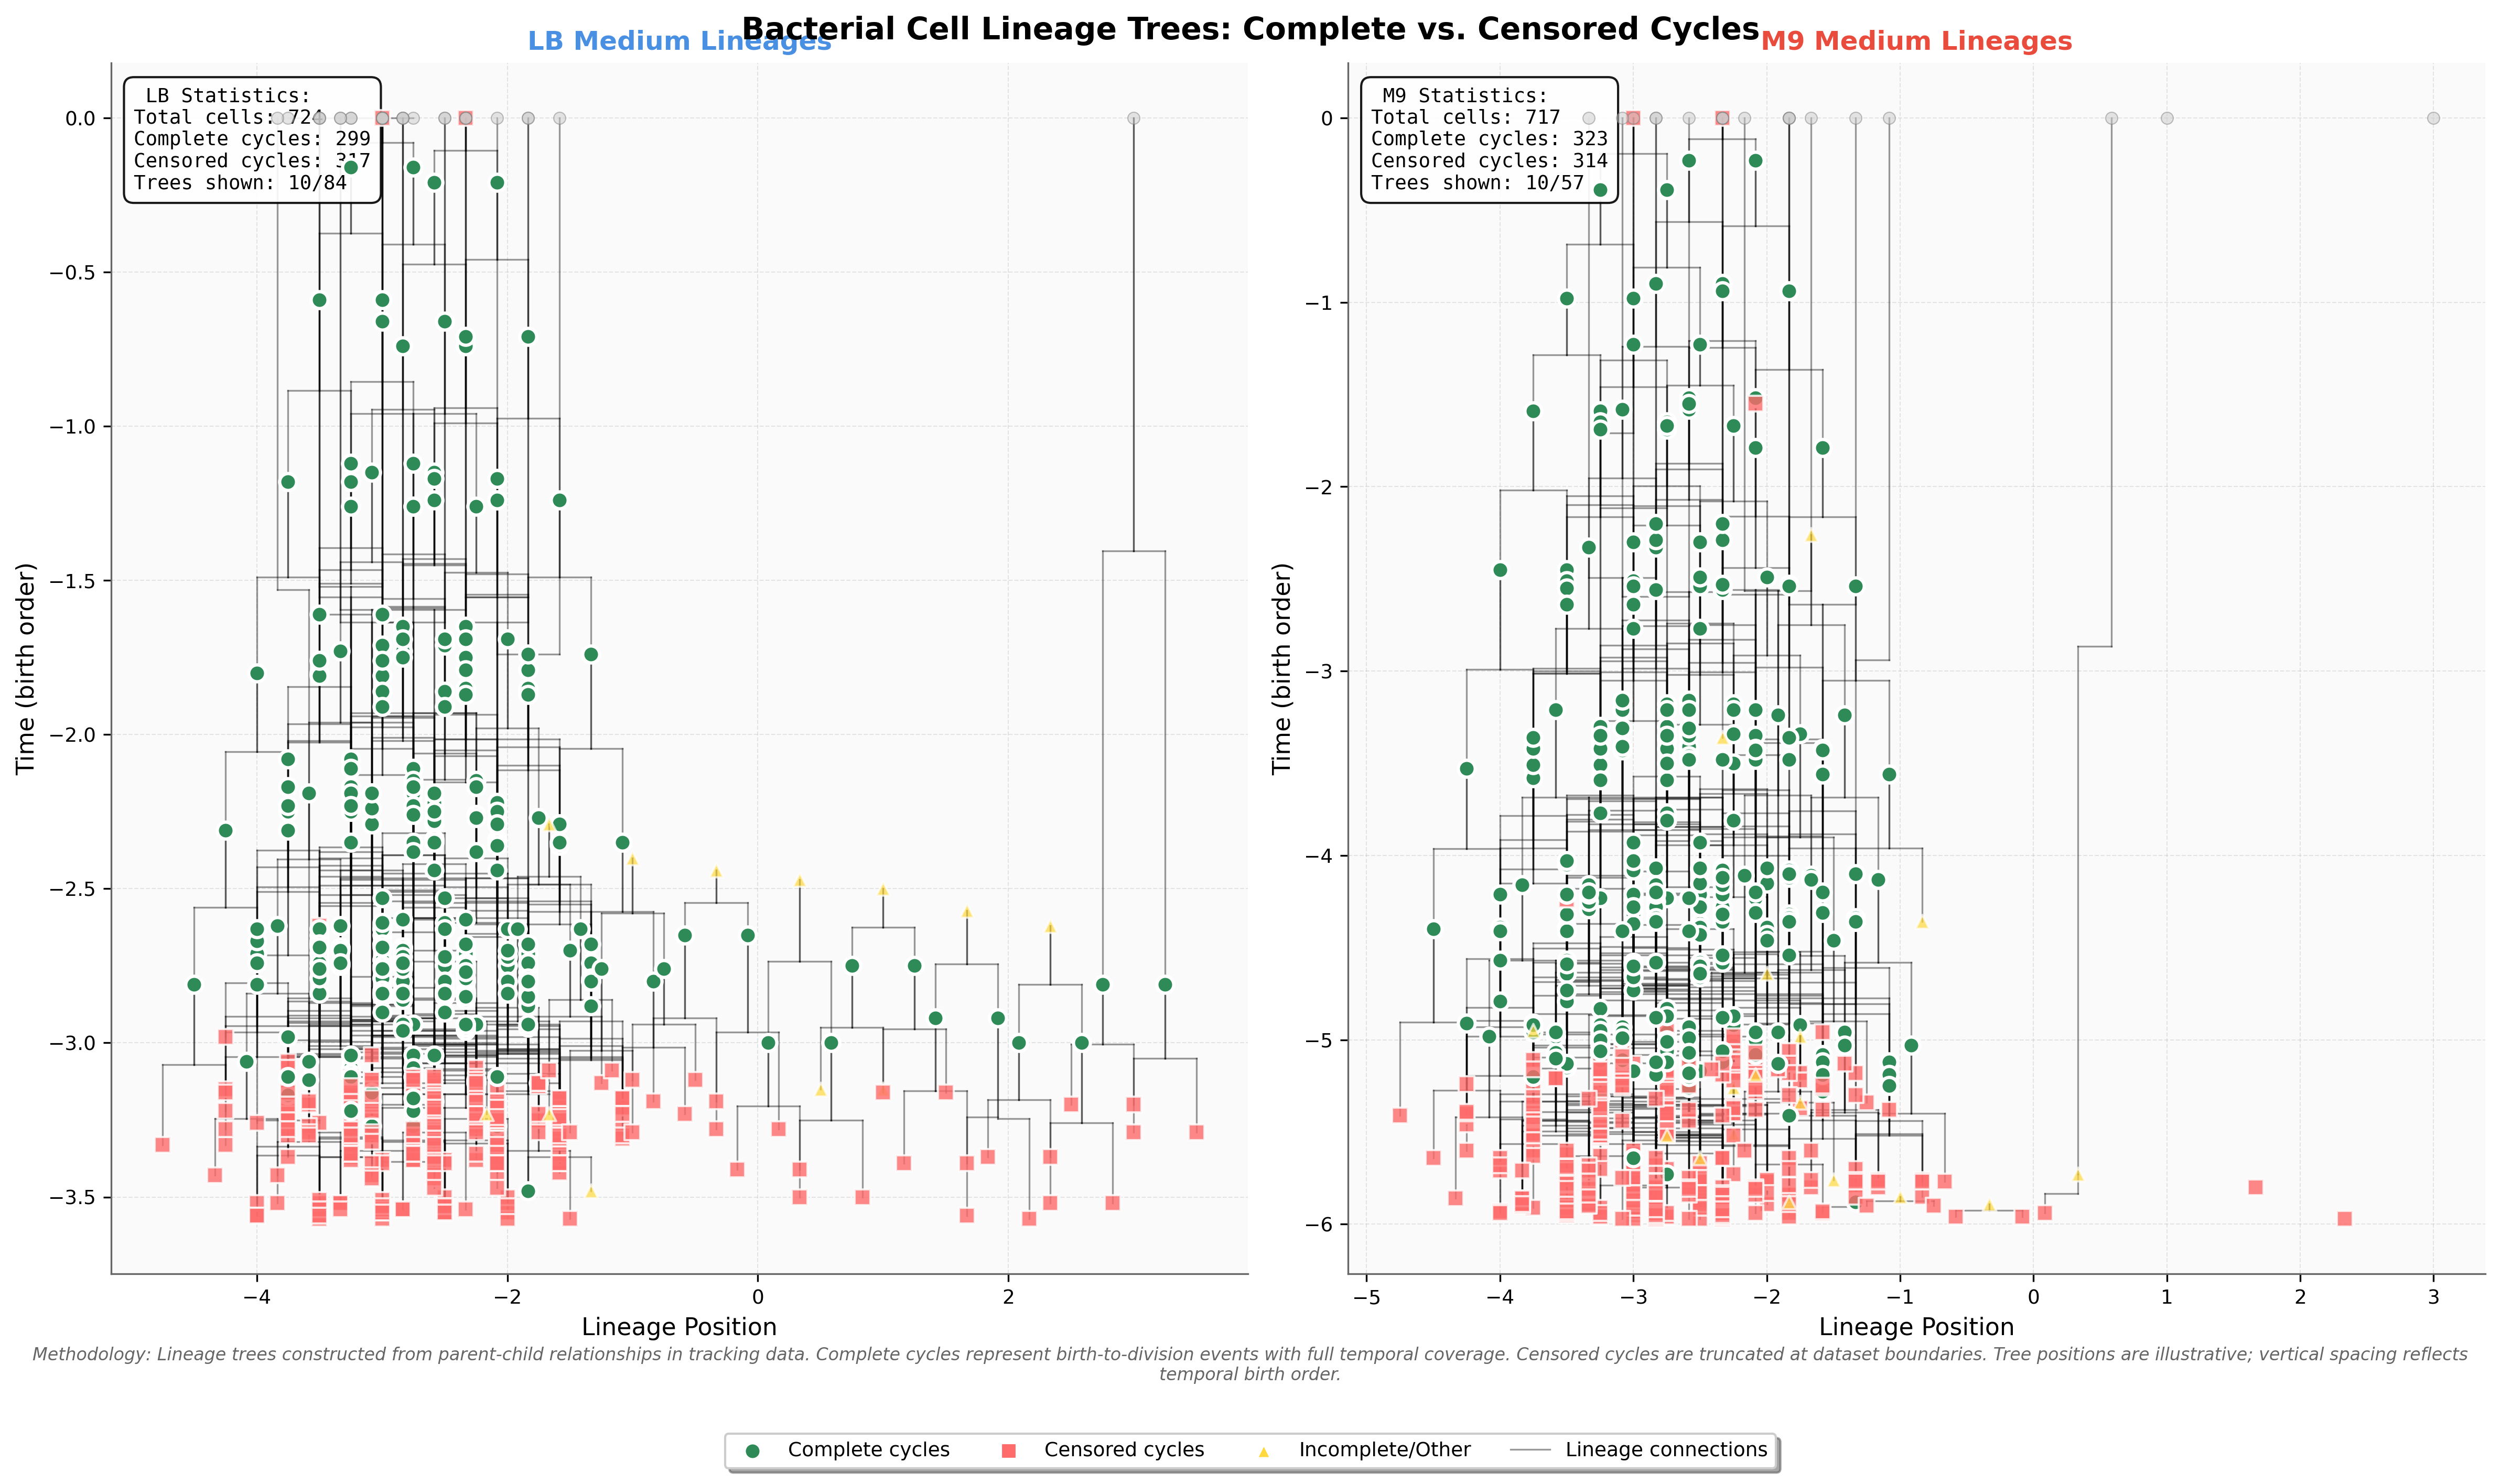


🌳 LINEAGE TREE ANALYSIS

LB Medium:
  Total lineage trees: 84
  Largest tree depth: 9
  Average tree size: 8.6 cells
  Tree size range: 1 - 295 cells
  Complete cycle rate: 48.5%
  Censoring rate: 51.5%

M9 Medium:
  Total lineage trees: 57
  Largest tree depth: 10
  Average tree size: 12.6 cells
  Tree size range: 1 - 329 cells
  Complete cycle rate: 50.7%
  Censoring rate: 49.3%
 Publication-ready lineage trees saved to /Users/lucas/Documents/GitHub/ECT/notebooks/05_tracking_analysis/results/cycle_analysis/lineage_trees_publication.pdf
 PNG version saved to /Users/lucas/Documents/GitHub/ECT/notebooks/05_tracking_analysis/results/cycle_analysis/lineage_trees_publication.png


In [14]:
# =====================================================================
# PUBLICATION-READY LINEAGE TREE VISUALIZATION
# =====================================================================

def build_lineage_trees(tracks_df, cycles_df, medium_name):
    """
    Build hierarchical lineage trees from tracking data.
    
    Returns:
    - lineage_trees: Dict of root_id -> tree structure
    - tree_stats: Summary statistics for each tree
    """
    
    # Get parent-child relationships
    parent_children = {}
    for _, track in tracks_df.groupby('track_id'):
        track_id = track['track_id'].iloc[0]
        parent = track['parent'].iloc[0]
        
        if pd.notna(parent):
            if parent not in parent_children:
                parent_children[parent] = []
            parent_children[parent].append(track_id)
    
    # Find root cells (no parents)
    all_tracks = set(tracks_df['track_id'].unique())
    has_parent = set()
    for children in parent_children.values():
        has_parent.update(children)
    
    root_tracks = all_tracks - has_parent
    
    def build_tree_recursive(track_id, depth=0):
        """Recursively build tree structure"""
        cycle_info = cycles_df[cycles_df['cell_id'] == track_id]
        
        node = {
            'track_id': track_id,
            'depth': depth,
            'children': [],
            'cycle_info': cycle_info.iloc[0] if len(cycle_info) > 0 else None
        }
        
        # Add children
        if track_id in parent_children:
            for child_id in parent_children[track_id]:
                child_node = build_tree_recursive(child_id, depth + 1)
                node['children'].append(child_node)
        
        return node
    
    # Build trees for each root
    lineage_trees = {}
    tree_stats = {}
    
    for root_id in root_tracks:
        tree = build_tree_recursive(root_id)
        
        # Calculate tree statistics
        def calculate_tree_stats(node):
            stats = {
                'total_cells': 1,
                'max_depth': node['depth'],
                'valid_cycles': 0,
                'censored_cycles': 0,
                'total_generations': 0
            }
            
            if node['cycle_info'] is not None:
                if node['cycle_info']['is_valid_cycle']:
                    stats['valid_cycles'] = 1
                    stats['total_generations'] = 1
                elif node['cycle_info']['is_censored_left'] or node['cycle_info']['is_censored_right']:
                    stats['censored_cycles'] = 1
            
            # Aggregate children stats
            for child in node['children']:
                child_stats = calculate_tree_stats(child)
                stats['total_cells'] += child_stats['total_cells']
                stats['max_depth'] = max(stats['max_depth'], child_stats['max_depth'])
                stats['valid_cycles'] += child_stats['valid_cycles']
                stats['censored_cycles'] += child_stats['censored_cycles']
                stats['total_generations'] += child_stats['total_generations']
            
            return stats
        
        tree_stats[root_id] = calculate_tree_stats(tree)
        lineage_trees[root_id] = tree
    
    return lineage_trees, tree_stats

def plot_lineage_tree(tree, ax, x_offset=0, y_spacing=1.0, time_scale=1.0):
    """
    Plot a single lineage tree with proper temporal positioning.
    """
    positions = {}  # track_id -> (x, y) position
    
    def assign_positions(node, x_pos, y_base):
        """Recursively assign x,y positions to nodes"""
        track_id = node['track_id']
        
        # Y position based on birth time
        if node['cycle_info'] is not None:
            birth_time = node['cycle_info']['birth_time_min']
            y_pos = y_base - (birth_time * time_scale)
        else:
            y_pos = y_base
        
        positions[track_id] = (x_pos, y_pos)
        
        # Position children
        if node['children']:
            child_x_spacing = 0.5
            start_x = x_pos - (len(node['children']) - 1) * child_x_spacing / 2
            
            for i, child in enumerate(node['children']):
                child_x = start_x + i * child_x_spacing
                assign_positions(child, child_x, y_base)
    
    # Assign positions starting from x_offset
    assign_positions(tree, x_offset, 0)
    
    # Plot connections (parent-child lines)
    def plot_connections(node):
        if node['children']:
            parent_pos = positions[node['track_id']]
            
            for child in node['children']:
                child_pos = positions[child['track_id']]
                
                # Draw L-shaped connection
                mid_y = (parent_pos[1] + child_pos[1]) / 2
                
                # Horizontal line from parent to division point
                ax.plot([parent_pos[0], parent_pos[0]], 
                       [parent_pos[1], mid_y], 
                       'k-', alpha=0.4, linewidth=0.8)
                
                # Horizontal line at division
                ax.plot([parent_pos[0], child_pos[0]], 
                       [mid_y, mid_y], 
                       'k-', alpha=0.4, linewidth=0.8)
                
                # Vertical line to child
                ax.plot([child_pos[0], child_pos[0]], 
                       [mid_y, child_pos[1]], 
                       'k-', alpha=0.4, linewidth=0.8)
                
                plot_connections(child)
    
    plot_connections(tree)
    
    # Plot nodes with cycle status encoding
    def plot_nodes(node):
        track_id = node['track_id']
        x, y = positions[track_id]
        
        if node['cycle_info'] is not None:
            cycle = node['cycle_info']
            
            # Color and style based on cycle status
            if cycle['is_valid_cycle']:
                color = '#2E8B57'  # Sea green for complete cycles
                marker = 'o'
                size = 60
                alpha = 1.0
                edge_color = 'white'
                edge_width = 1.5
            elif cycle['is_censored_left'] or cycle['is_censored_right']:
                color = '#FF6B6B'  # Coral for censored cycles
                marker = 's'  # Square for censored
                size = 50
                alpha = 0.8
                edge_color = 'white'
                edge_width = 1.0
            else:
                color = '#FFD93D'  # Yellow for incomplete/other
                marker = '^'  # Triangle for other
                size = 40
                alpha = 0.7
                edge_color = 'white'
                edge_width = 1.0
        else:
            # No cycle info
            color = '#CCCCCC'
            marker = 'o'
            size = 30
            alpha = 0.5
            edge_color = 'gray'
            edge_width = 0.5
        
        ax.scatter(x, y, c=color, marker=marker, s=size, alpha=alpha, 
                  edgecolors=edge_color, linewidths=edge_width, zorder=10)
        
        # Plot children
        for child in node['children']:
            plot_nodes(child)
    
    plot_nodes(tree)
    
    return positions

def create_lineage_forest_plot():
    """
    Create publication-ready side-by-side lineage tree visualization.
    """
    
    # Set up the figure with high DPI for publication
    plt.rcParams.update({
        'figure.dpi': 300,
        'savefig.dpi': 300,
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 11,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9
    })
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    fig.suptitle('Bacterial Cell Lineage Trees: Complete vs. Censored Cycles', 
                 fontsize=14, fontweight='bold', y=0.95)
    
    medium_colors = {'LB': '#4A90E2', 'M9': '#E94B3C'}
    
    for idx, (medium, tracks_df) in enumerate(tracks_data.items()):
        ax = axes[idx]
        cycles_df = cycle_data[medium]
        
        # Build lineage trees
        trees, tree_stats = build_lineage_trees(tracks_df, cycles_df, medium)
        
        # Select representative trees (largest ones for visibility)
        sorted_trees = sorted(tree_stats.items(), 
                            key=lambda x: x[1]['total_cells'], reverse=True)
        
        # Select top 8-12 trees for clear visualization
        max_trees = min(10, len(sorted_trees))
        selected_trees = sorted_trees[:max_trees]
        
        # Calculate time scale for proper temporal positioning
        all_birth_times = []
        for _, cycle in cycles_df.iterrows():
            if pd.notna(cycle['birth_time_min']):
                all_birth_times.append(cycle['birth_time_min'])
        
        if all_birth_times:
            time_range = max(all_birth_times) - min(all_birth_times)
            time_scale = 0.02 if time_range > 0 else 0.01  # Adjust scale for visibility
        else:
            time_scale = 0.01
        
        # Plot trees with horizontal spacing
        x_positions = np.linspace(-3, 3, max_trees)
        
        for i, (root_id, stats) in enumerate(selected_trees):
            tree = trees[root_id]
            plot_lineage_tree(tree, ax, x_offset=x_positions[i], 
                            y_spacing=1.0, time_scale=time_scale)
        
        # Customize axes
        ax.set_title(f'{medium} Medium Lineages', fontsize=12, fontweight='bold',
                    color=medium_colors[medium])
        ax.set_xlabel('Lineage Position', fontsize=11)
        ax.set_ylabel('Time (birth order)', fontsize=11)
        
        # Remove top and right spines for cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#666666')
        ax.spines['bottom'].set_color('#666666')
        
        # Set background color
        ax.set_facecolor('#FAFAFA')
        
        # Add grid for better readability
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        
        # Calculate and display summary statistics
        total_cells = sum(stats['total_cells'] for stats in tree_stats.values())
        valid_cycles = cycles_df['is_valid_cycle'].sum()
        censored_cycles = (cycles_df['is_censored_left'] | cycles_df['is_censored_right']).sum()
        
        # Add statistics text box
        stats_text = (
            f" {medium} Statistics:\n"
            f"Total cells: {total_cells}\n"
            f"Complete cycles: {valid_cycles}\n"
            f"Censored cycles: {censored_cycles}\n"
            f"Trees shown: {max_trees}/{len(trees)}"
        )
        
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
               verticalalignment='top', horizontalalignment='left',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9),
               fontsize=9, family='monospace')
    
    # Create comprehensive legend
    legend_elements = [
        plt.scatter([], [], c='#2E8B57', marker='o', s=60, 
                   edgecolors='white', linewidths=1.5, 
                   label='Complete cycles'),
        plt.scatter([], [], c='#FF6B6B', marker='s', s=50, 
                   edgecolors='white', linewidths=1.0, 
                   label='Censored cycles'),
        plt.scatter([], [], c='#FFD93D', marker='^', s=40, 
                   edgecolors='white', linewidths=1.0, 
                   label='Incomplete/Other'),
        plt.Line2D([0], [0], color='black', alpha=0.4, linewidth=0.8, 
                   label='Lineage connections')
    ]
    
    fig.legend(handles=legend_elements, loc='lower center', ncol=4, 
              bbox_to_anchor=(0.5, 0.02), frameon=True, fancybox=True, shadow=True)
    
    # Add methodology note
    method_text = (
        "Methodology: Lineage trees constructed from parent-child relationships in tracking data. "
        "Complete cycles represent birth-to-division events with full temporal coverage. "
        "Censored cycles are truncated at dataset boundaries. Tree positions are illustrative; "
        "vertical spacing reflects temporal birth order."
    )
    
    fig.text(0.5, 0.08, method_text, ha='center', va='bottom', fontsize=8, 
            style='italic', wrap=True, color='#666666')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15, top=0.92)
    
    # Save high-resolution version
    output_file = OUTPUT_DIR / 'lineage_trees_publication.pdf'
    plt.savefig(output_file, dpi=300, bbox_inches='tight', 
               facecolor='white', edgecolor='none')
    
    output_file_png = OUTPUT_DIR / 'lineage_trees_publication.png'
    plt.savefig(output_file_png, dpi=300, bbox_inches='tight', 
               facecolor='white', edgecolor='none')
    
    plt.show()
    
    # Print tree summary statistics
    print("\n🌳 LINEAGE TREE ANALYSIS")
    print("=" * 50)
    
    for medium, tracks_df in tracks_data.items():
        cycles_df = cycle_data[medium]
        trees, tree_stats = build_lineage_trees(tracks_df, cycles_df, medium)
        
        print(f"\n{medium} Medium:")
        print(f"  Total lineage trees: {len(trees)}")
        print(f"  Largest tree depth: {max(stats['max_depth'] for stats in tree_stats.values())}")
        print(f"  Average tree size: {np.mean([stats['total_cells'] for stats in tree_stats.values()]):.1f} cells")
        
        # Tree size distribution
        tree_sizes = [stats['total_cells'] for stats in tree_stats.values()]
        print(f"  Tree size range: {min(tree_sizes)} - {max(tree_sizes)} cells")
        
        # Cycle completeness across trees
        total_valid = sum(stats['valid_cycles'] for stats in tree_stats.values())
        total_censored = sum(stats['censored_cycles'] for stats in tree_stats.values())
        total_cycles = total_valid + total_censored
        
        if total_cycles > 0:
            print(f"  Complete cycle rate: {total_valid/total_cycles*100:.1f}%")
            print(f"  Censoring rate: {total_censored/total_cycles*100:.1f}%")
    
    success(f"Publication-ready lineage trees saved to {output_file}")
    success(f"PNG version saved to {output_file_png}")

# Generate the lineage tree visualization
create_lineage_forest_plot()
